# HIV SMILES String dataset:<br> for GNN classification

## Load HIV dataset

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("HIV.csv")
df.head()

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


In [3]:
string = df.loc[0,'smiles']
print(df.loc[0,'smiles'])
print(string[3])

CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)=[O+]2
1


In [4]:
df.value_counts("activity")

activity
CI    39684
CM     1039
CA      404
Name: count, dtype: int64

In [5]:
df.value_counts("HIV_active")

HIV_active
0    39684
1     1443
Name: count, dtype: int64

CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)=[O+]2


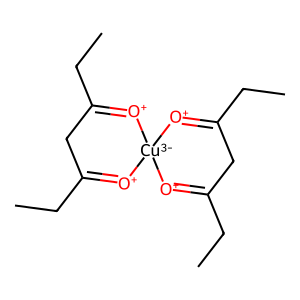

In [6]:
from rdkit import Chem
from rdkit.Chem import Draw
import networkx as nx

smiles = df['smiles'].iloc[0]
print(smiles)

# Visualizing the first molecule's structure as an example
mol = Chem.MolFromSmiles(smiles)
Draw.MolToImage(mol)

In [7]:
df_CI = df[df['HIV_active'] == 0]
df_CA = df[df['HIV_active'] == 1]

# Sampling from each category
val_CI = df_CI.sample(n=50, random_state=42) 
val_CA = df_CA.sample(n=50, random_state=42)

# Concatenate the samples back into one DataFrame
val_df = pd.concat([val_CI, val_CA])

# Shuffle the combined DataFrame
print(val_df.value_counts("HIV_active"))
val_df

HIV_active
0    50
1    50
Name: count, dtype: int64


,smiles,activity,HIV_active
2428,O=C1c2ccccc2-c2nc3ccccc3nc21,CI,0
6197,O=C(CSc1cc(-c2ccc(Cl)cc2)s[s+]1)c1ccccc1,CI,0
17138,O=C(C=Nc1ccccc1C(=O)O)c1ccco1,CI,0
12261,CCCCCCCCCCCCCCCCCC[N+](C)(C)Cc1ccc(C[N+](C)(C)...,CI,0
3588,N#CSC1CCCCCCC1SC#N,CI,0
...,...,...,...
24663,COc1ccc(N2C(=O)c3c4c(c5c([nH]c6ncccc65)c3C2=O)...,CM,1
1637,Cc1c2ccccc2n[c-](CSc2ccccc2)[n+]1=O,CA,1
40015,S=c1[nH]nc(-c2ccccc2Nc2ccccc2-c2n[nH]c(=S)n2-c...,CM,1
18430,O=c1c2ccccc2[se]n1-c1ccc(Cl)cc1,CM,1


In [8]:
train_df = df.drop(val_df.index)
print(train_df.value_counts("HIV_active"))
train_df

HIV_active
0    39634
1     1393
Name: count, dtype: int64


,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0
...,...,...,...
41122,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,CI,0
41123,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,CI,0
41124,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,CI,0
41125,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,CI,0


In [9]:
val_df = val_df.reset_index(drop=True)
train_df = train_df.reset_index(drop=True)

## Transform SMILES into Graph representation

In [10]:
from torch_geometric.data import Data

# Atom and bond preprocessing functions
def atom_features(atom):
    return [
        atom.GetAtomicNum(),             # Atomic number
        atom.GetFormalCharge(),          # Formal charge
        atom.GetDegree(),                # Degree of the atom
        int(atom.GetHybridization()),    # Hybridization
        atom.GetIsAromatic(),            # Aromaticity
        atom.GetImplicitValence(),       # Implicit valence
        atom.GetMass(),                  # Atomic mass 
        atom.GetTotalDegree(),           # Total number of bonds
        atom.GetTotalValence(),          # Total valence electrons
    ]

def bond_features(bond):
    bt = bond.GetBondType()
    return [
        int(bt == Chem.rdchem.BondType.SINGLE),
        int(bt == Chem.rdchem.BondType.DOUBLE),
        int(bt == Chem.rdchem.BondType.TRIPLE),
        int(bt == Chem.rdchem.BondType.AROMATIC),
        bond.GetIsConjugated(),  # Conjugation
        bond.IsInRing(),         # Whether the bond is in a ring
    ]

In [11]:
# Padding 
def normalize_features(features, max_length):
    """Normalize feature list to a specific length."""
    feature_length = len(features[0])
    if len(features) < max_length:
        # Pad with zeros if there are not enough features
        features += [[0] * feature_length] * (max_length - len(features))
    return [item for sublist in features for item in sublist][:max_length * feature_length]

In [12]:
def smiles_to_graph(smiles, radius=2, max_neighbors=10):
    """Convert SMILES to graph data with consistent node features."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    mol = Chem.AddHs(mol)
    atoms = mol.GetAtoms()
    bonds = mol.GetBonds()

    # Initialize fingerprints
    fingerprint_dict = {atom.GetIdx(): atom_features(atom) for atom in atoms}

    # Weisfeiler-Lehman iteration to update fingerprints
    for _ in range(radius):
        new_fingerprint_dict = {}
        for atom in atoms:
            idx = atom.GetIdx()
            neighbors = [bond.GetOtherAtomIdx(idx) for bond in atom.GetBonds()]
            neighbor_fingerprints = [fingerprint_dict[neighbor] for neighbor in neighbors]
            # Normalize the length of fingerprints
            flat_fingerprint = normalize_features([fingerprint_dict[idx]] + neighbor_fingerprints, max_neighbors)
            new_fingerprint_dict[idx] = flat_fingerprint
        fingerprint_dict = new_fingerprint_dict

    # Convert fingerprints to tensors
    node_feats = [fingerprint_dict[atom.GetIdx()] for atom in atoms]
    node_feats = torch.tensor(node_feats, dtype=torch.float)

    # Edge index and attributes remain the same
    edge_index = []
    edge_attr = []
    for bond in bonds:
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append([i, j])
        edge_index.append([j, i])
        edge_features = bond_features(bond)
        edge_attr.append(edge_features)
        edge_attr.append(edge_features)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    return Data(x=node_feats, edge_index=edge_index, edge_attr=edge_attr)


# Apply the function to your dataframe
train_df['graph'] = train_df['smiles'].apply(smiles_to_graph)
val_df['graph'] = val_df['smiles'].apply(smiles_to_graph)
train_df

[00:38:09] WARNING: not removing hydrogen atom without neighbors
[00:38:09] WARNING: not removing hydrogen atom without neighbors


,smiles,activity,HIV_active,graph
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0,"[(x, [tensor([ 6.0000, 0.0000, 4.0000, 4.00..."
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0,"[(x, [tensor([ 6.0000, 0.0000, 3.0000, 3.00..."
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0,"[(x, [tensor([ 6.0000, 0.0000, 4.0000, 4.00..."
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0,"[(x, [tensor([ 7.0000, 0.0000, 3.0000, 3.00..."
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0,"[(x, [tensor([ 8.0000, 0.0000, 1.0000, 3.00..."
...,...,...,...,...
41022,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,CI,0,"[(x, [tensor([ 6.0000, 0.0000, 4.0000, 4.00..."
41023,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,CI,0,"[(x, [tensor([ 6.0000, 0.0000, 4.0000, 4.00..."
41024,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,CI,0,"[(x, [tensor([ 6.0000, 0.0000, 4.0000, 4.00..."
41025,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,CI,0,"[(x, [tensor([ 6.0000, 0.0000, 4.0000, 4.00..."


## GNN

In [13]:
for i, data in enumerate(train_df['graph']):
    data.y = torch.tensor([train_df['HIV_active'][i]], dtype=torch.long)
print(train_df['graph'][0])

Data(x=[43, 900], edge_index=[2, 88], edge_attr=[88, 6], y=[1])


In [14]:
for i, data in enumerate(val_df['graph']):
    data.y = torch.tensor([val_df['HIV_active'][i]], dtype=torch.long)
print(val_df['graph'][0])

Data(x=[26, 900], edge_index=[2, 58], edge_attr=[58, 6], y=[1])


In [15]:
import random
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader 

def graph_dataloader(dataset, batch_size=32):
    while True:
        index_list=[]
        df_CI = dataset[dataset['HIV_active'] == 0]
        df_CA = dataset[dataset['HIV_active'] == 1]
        sample_CI = df_CI.sample(n=1500)
        sample_CA = df_CA.sample(n=1000)
        index_list = sample_CI.index
        #print(index_list)
        sampled_sf = pd.concat([sample_CI, sample_CA])
        sampled_sf = sampled_sf.sample(frac=1).reset_index(drop=True)
        graph_dataset = sampled_sf['graph'].tolist()
        yield DataLoader(graph_dataset, batch_size=batch_size, shuffle=True)
        

train_loader = graph_dataloader(train_df, batch_size=32)
val_loader = DataLoader(val_df['graph'], batch_size=32, shuffle=True)

In [16]:
import torch.optim as optim
from tqdm import tqdm
from torch.nn import Linear, ReLU, Sequential
from torch_geometric.utils import scatter
from torch_geometric.loader import DataLoader as GraphDataLoader

class Layer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.layers = Sequential(
            Linear(in_dim, out_dim),
            ReLU()
        )
    
    def forward(self, x):
        return self.layers(x)

class MessagePassingLayer(nn.Module):
    def __init__(self, node_hidden_dim, edge_hidden_dim):
        super().__init__()
        self.edge_net = Layer(2 * node_hidden_dim + edge_hidden_dim, edge_hidden_dim)
        self.node_net = Layer(node_hidden_dim + edge_hidden_dim, node_hidden_dim)
    
    def forward(self, node_features, edge_features, edge_index):
        src, dest = edge_index[0], edge_index[1]
        edge_features_combined = torch.cat([
            node_features[src],
            node_features[dest],
            edge_features
        ], dim=1)
        updated_edge_features = self.edge_net(edge_features_combined)
        aggr_edge_features = scatter(updated_edge_features, src, dim_size=node_features.size(0))
        node_features_combined = torch.cat([node_features, aggr_edge_features], dim=1)
        updated_node_features = self.node_net(node_features_combined)
        return updated_node_features, updated_edge_features

class GraphNet(nn.Module):
    def __init__(self, node_input_dim, edge_input_dim, node_hidden_dim, edge_hidden_dim, num_classes):
        super().__init__()
        self.node_embed = Layer(node_input_dim, node_hidden_dim)
        self.edge_embed = Layer(edge_input_dim, edge_hidden_dim)
        self.message_passing = MessagePassingLayer(node_hidden_dim, edge_hidden_dim)
        self.readout = Linear(node_hidden_dim, num_classes)
    
    def forward(self, data):
        node_hidden = self.node_embed(data.x)
        edge_hidden = self.edge_embed(data.edge_attr)
        node_hidden, edge_hidden = self.message_passing(node_hidden, edge_hidden, data.edge_index)
        graph_embeddings = scatter(node_hidden, data.batch, dim=0)
        out = self.readout(graph_embeddings)
        return out

In [33]:
from sklearn.metrics import confusion_matrix

class GNNTrainer:
    def __init__(self, model, batch_size=32, learning_rate=1e-3, epoch=10, l2=1e-5):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.batch_size = batch_size
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
        self.epoch = epoch
        
    def train(self, train_loader, draw_curve=True):  
        self.model.train()
        loss_func = nn.CrossEntropyLoss()
        batch_loss_list = []
        for i in range(self.epoch):
            print(f"Epoch: {i}")
            
            for batch_data in tqdm(next(train_loader), leave=False):
                self.optimizer.zero_grad()
                batch_pred = self.model(batch_data)  # Assume model handles the batch_data correctly
                batch_loss = loss_func(batch_pred, batch_data.y)
                batch_loss.backward()
                self.optimizer.step()

                batch_loss_list.append(batch_loss.item())
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            ax.plot(np.arange(len(batch_loss_list)), batch_loss_list)
            ax.set_xlabel("# Batch")
            ax.set_ylabel("Loss")
            plt.show()
        
        return batch_loss_list
    
    def evaluate(self, val_loader, draw_curve=True):
        self.model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for batch_data in tqdm(val_loader, leave=False):
                batch_pred = self.model(batch_data)
                y_pred.extend(batch_pred.argmax(dim=1).cpu().numpy())
                y_true.extend(batch_data.y.cpu().numpy())
        
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        accuracy = np.mean(y_true == y_pred)
        
        if draw_curve:
            cm = confusion_matrix(y_true, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
            plt.title("Confusion Matrix")
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()
            
        return accuracy

In [34]:
num_classes = 2  # HIV_active: 0/ 1
node_input_dim = train_df['graph'][0].x.shape[1] 
edge_input_dim = train_df['graph'][0].edge_attr.shape[1]  
node_hidden_dim = 64
edge_hidden_dim = 64
model = GraphNet(node_input_dim, edge_input_dim, node_hidden_dim, edge_hidden_dim, num_classes)

GraphNet - Number of parameters: 78850
Epoch: 0


Epoch: 1


Epoch: 2


Epoch: 3


Epoch: 4


Epoch: 5


Epoch: 6


Epoch: 7


Epoch: 8


Epoch: 9


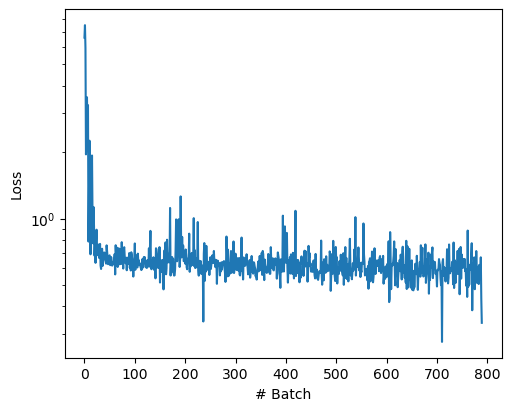

[6.618364334106445,
 7.536685466766357,
 5.9248175621032715,
 1.9557247161865234,
 2.2525534629821777,
 3.5502572059631348,
 2.4943182468414307,
 3.2696406841278076,
 0.7867574095726013,
 1.419029951095581,
 2.255678415298462,
 1.3976527452468872,
 0.6886756420135498,
 0.9540421366691589,
 1.1484575271606445,
 1.9324017763137817,
 1.0424293279647827,
 0.7725745439529419,
 1.1291004419326782,
 0.9177147746086121,
 0.678869366645813,
 0.782090961933136,
 0.6299792528152466,
 0.7831066846847534,
 0.8905925750732422,
 0.6867638230323792,
 0.6826989054679871,
 0.7379636764526367,
 0.7625718116760254,
 0.6637299060821533,
 0.7261173129081726,
 0.7674835920333862,
 0.6124930381774902,
 0.5909879207611084,
 0.6561313271522522,
 0.7298105955123901,
 0.6097486615180969,
 0.6454639434814453,
 0.6516624689102173,
 0.7022385001182556,
 0.6665919423103333,
 0.6966112852096558,
 0.637997567653656,
 0.6248542070388794,
 0.7561036348342896,
 0.704840898513794,
 0.6469936966896057,
 0.6212140917778015,


In [35]:
trainer = GNNTrainer(model)
trainer.train(train_loader)

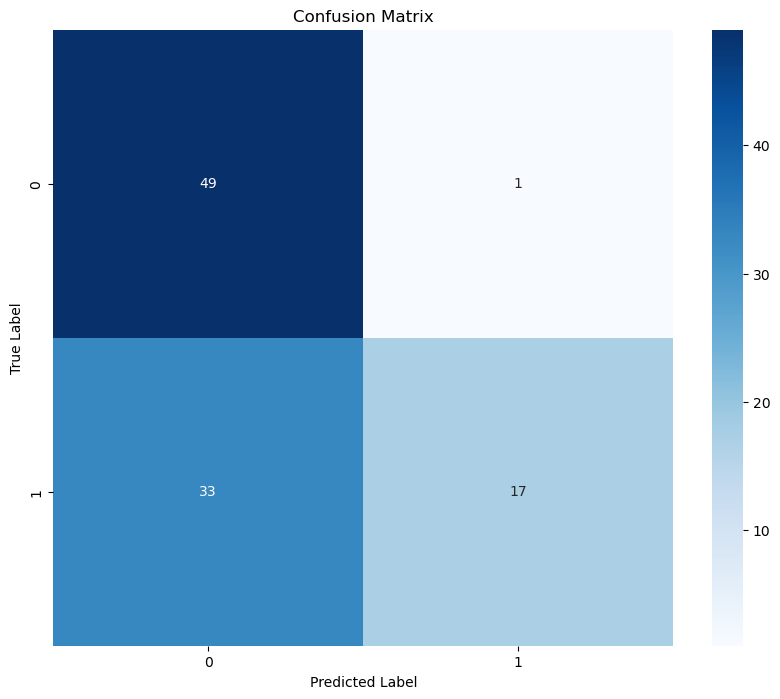

0.66

In [36]:
# evaulate
trainer.evaluate(val_loader)